In [1]:
import numpy as np


In [2]:
def dcg(rank, relevances):
    totals = []
    total = 0
    for i in range(1,rank+1):
        pd = 1/np.log2(1+i)
        #print("Position discount=", pd)
        to_add = (2**relevances[i-1] - 1)*pd
        total += to_add
        totals.append(total)
        print("i=", i, "DCG=", total)
    return np.array(totals)

def dcg_other(rank, relevances):
    total=relevances[0]
    for i in range(2,rank+1):
         total +=relevances[i-1]/(np.log2(i))
    return total

def ndcg(rank, relevances, gt):
    return np.round(dcg(rank, relevances)/dcg(rank, gt), 2)

In [3]:
hp = [3,3,2,2,1,1,1]
hl = [2,3,2,3,1,1,1]
ndcg(4, hl, hp)

i= 1 DCG= 3.0
i= 2 DCG= 7.4165082750002025
i= 3 DCG= 8.916508275000202
i= 4 DCG= 11.931244181513954
i= 1 DCG= 7.0
i= 2 DCG= 11.416508275000202
i= 3 DCG= 12.916508275000202
i= 4 DCG= 14.208537949220382


array([0.43, 0.65, 0.69, 0.84])

In [4]:
pr = [2,2,1,0]
br = [2,1,2,0]
ndcg(4,br,pr)

i= 1 DCG= 3.0
i= 2 DCG= 3.6309297535714578
i= 3 DCG= 5.130929753571458
i= 4 DCG= 5.130929753571458
i= 1 DCG= 3.0
i= 2 DCG= 4.892789260714372
i= 3 DCG= 5.392789260714372
i= 4 DCG= 5.392789260714372


array([1.  , 0.74, 0.95, 0.95])

In [5]:
def ap_q(k, rels):
    total=0
    for i in range(1,k+1):
        p_i = np.count_nonzero(rels[:i])/i
        total += p_i*rels[i-1]
    return total/np.count_nonzero(rels)

def mean_ap(k, relevances):
    total = 0 #relevances is list of relevances one per query.
    for rels in relevances:
        total += ap_q(k,rels)
    return total/len(rels)

In [6]:
ap_q(5, [1,0,1,0,1])

0.7555555555555555

In [7]:
mean_ap(3, [[1,0,1,0,1], [1,2,1,0,1], [0,0,0,0,3], [3,0,0,0,0], [0,3,0,0,0]])

1.211111111111111

## Regression

Find a function to give rank

In [8]:

relevance = np.array([3,2,2,2,1,1,1,0,0,0])
feature = np.array([7,2,1,3,1,0,0,1,0,0])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(feature, relevance, 'b.')
plt.xlabel="No. query terms in document"
plt.ylabel="Relevance"
plt.savefig("./images/regression.png", bbox_inches='tight')

plt.show();

<Figure size 640x480 with 1 Axes>

In [9]:
import numpy.linalg as la


In [10]:
feature=feature.reshape(1,-1)
relevance = relevance.reshape(1,-1)
n = feature.shape[1]
X = np.concatenate([feature, np.ones(n).reshape(1,-1)], axis=0)
y = relevance
w = np.dot(y, la.pinv(X))
print(w)

[[0.37647059 0.63529412]]


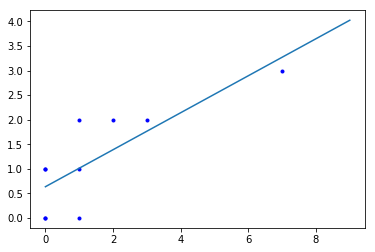

In [11]:
plt.figure()
plt.plot(feature, relevance, 'b.')
plt.xlabel="No. query terms in document"
plt.ylabel="Relevance"
x = np.arange(n).reshape(1,-1)
x_1 = np.concatenate([x, np.ones(n).reshape(1,-1)], axis=0)
res = np.dot(w,x_1).ravel()
plt.plot(x.ravel(), res)

plt.savefig("./images/regression_line.png", bbox_inches='tight');


## Pranking

Perceptron based ranking

In [12]:
def plot_update(w, i):
    x_plot = np.arange(-4, 4, 1)
    y_plot =  -(w[0]/w[1]*x_plot + w[2]/w[1]);
    
    plt.figure()
    plt.plot(x_1[:,0], x_1[:,1], 'b.')
    plt.plot(x_2[:,0], x_2[:,1], 'r.')
    plt.plot(x_plot, y_plot)
    plt.plot(X[i,0], X[i,1], 'mo')
    plt.show()
    
def perceptron(X, y, eta, runs):
    w = np.random.rand(X.shape[1])-0.5
    #w = [1,1,0]
    n = X.shape[0]
    for i in range(runs):
        r_idx = np.random.randint(n)  
        y_hat = np.dot(X,w)
        y_hat_err = len(np.where(y*y_hat<0)[0])       
        if y_hat[r_idx]*y[r_idx]< 0:
            w = w + eta*y[r_idx]*X[r_idx,:]
            plot_update(w, r_idx)
        if y_hat_err == 0:
            print("coverged")
            return w
    print("failed to converge")
    return w



In [13]:
mu_1 = [2,1]
mu_2 = [-2,-1]
C = [[.25, 0 ],[ 0, .25]]
A = la.cholesky(C);
N = 100
x_1 = np.random.multivariate_normal(mu_1, A, N)
x_2 = np.random.multivariate_normal(mu_2, A, N)

X = np.concatenate([x_1, x_2])
ones = np.ones(2*N).reshape(-1,1)

X = np.concatenate([X,ones], axis=1)
y = np.concatenate([np.ones(N), -np.ones(N)])


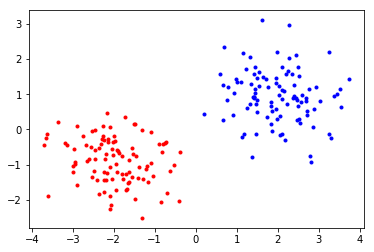

In [14]:
plt.plot(x_1[:,0], x_1[:,1], 'b.')
plt.plot(x_2[:,0], x_2[:,1], 'r.')

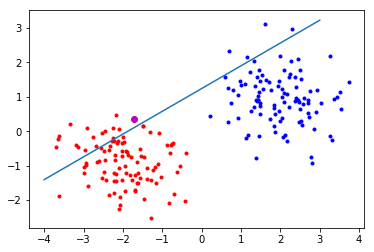

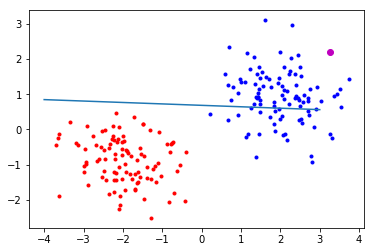

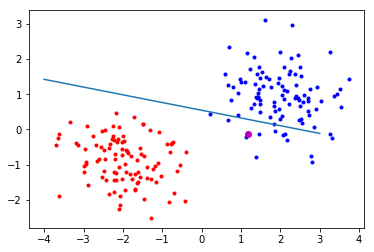

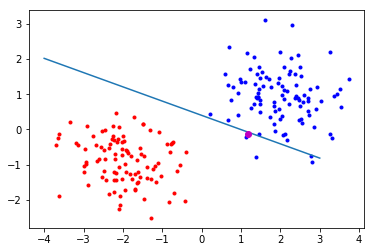

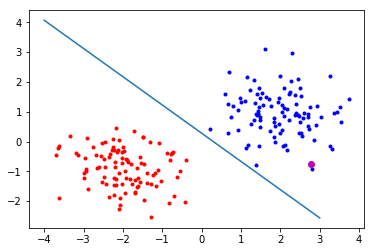

coverged
[ 0.54033309  0.57057373 -0.15900302]


In [15]:
w = perceptron(X, y, 0.1, 1000)
print(w)

## Perceptron Ranking

Using a perceptron like algorithm to update weight vector and intervals

In [163]:
def get_yhat_i(X, i, w, b):
    #get minimum rank for which xI.w - b_r <0
    for r in range(len(b)):
        if (np.dot(X[i,:], w) - b[r]) <0:
            return r+1
    #shouldn't get past this as taking away infinity should be lt 0
    print("gone wrong")
    
def get_yhat(X, w, b):
    y_hat = np.zeros(X.shape[0]) 
    for i in range(X.shape[0]):
        y_hat[i] = get_yhat_i(X, i, w, b)
    return y_hat
            
def is_all_right(y, y_hat):
    for i in range(len(y)):
        if y[i] != y_hat[i]:
            return False
    return True

def pranking(X, y, T, k):
    np.random.seed(1234)
    n = X.shape[0] #number of samples
    vl =X.shape[1] #feature vector length
    #w = np.random.rand(vl)-0.5
    w = np.zeros(vl)
    print(w)
    b = np.zeros(k-1)
    b = np.concatenate([b, [np.inf]])
    for i in range(T):
        y_hat = get_yhat(X, w, b)
        if is_all_right(y, y_hat):
            print("converged")
            return w,b
        r_idx = np.random.randint(n)  
        print(r_idx)
        y_hat_i = get_yhat_i(X, r_idx, w, b)
        print(y_hat_i)
        if y_hat_i != y[r_idx]:
            print(np.dot(X[r_idx,:], w))
            #make true rank vector
            trv = [-1 if y[r_idx]<= r+1 else 1 for r in range(k-1)]
            print(trv)
            #update w
            tau = [trv[r] if (np.dot(X[r_idx,:], w)-b[r])*trv[r]<=0 else 0 for r in range(k-1)]
            print(tau)
            w_new = w + sum(tau)*X[r_idx,:]
            #update b
            b = [b[r]-tau[r] for r in range(k-1)] + [np.inf]
            w = w_new
            print(b)
        
    return w, b


build sample data set, x_1 is proportion of hours worked, x_2 is proportion of lectures attended
ranks 1 = distinction, 2 = merit, 3 = pass, 4 = fail

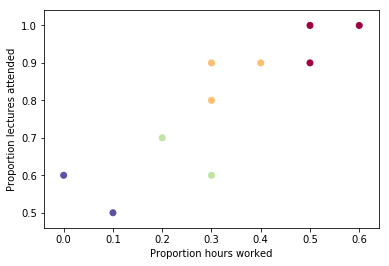

In [209]:
np.random.seed(1234)
X_rank = np.array([[0.4, 0.9], [0.3, 0.8], [0.2, 0.7], [0.3, 0.6], [0.5, 1], [0.3, 0.9], [0.6, 1], [0.1, 0.5], [0, 0.6], [0.5, 0.9]])
ones = np.ones(10).reshape(-1,1)
X_rank = np.concatenate([X_rank, ones], axis=1)
y = [2, 2, 3, 3, 1, 2, 1, 4, 4, 1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_rank[:, 0], X_rank[:,1],  c=y, cmap=plt.cm.Spectral)
ax.set_xlabel("Proportion hours worked")
ax.set_ylabel("Proportion lectures attended")

plt.savefig("./images/rank_plot.png", bbox_inches='tight');

In [205]:

w,b = pranking(X_rank, y, 1000, 4)

[0. 0. 0.]
3
4
0.0
[1, 1, -1]
[1, 1, -1]
[-1.0, -1.0, 1.0, inf]
6
4
1.78
[-1, -1, -1]
[-1, -1, -1]
[0.0, 0.0, 2.0, inf]
5
1
-4.609999999999999
[1, -1, -1]
[1, 0, 0]
[-1.0, 0.0, 2.0, inf]
4
1
8
1
-1.9
[1, 1, 1]
[1, 1, 1]
[-2.0, -1.0, 1.0, inf]
9
4
1.67
[-1, -1, -1]
[-1, -1, -1]
[-1.0, 0.0, 2.0, inf]
1
1
-3.7300000000000004
[1, -1, -1]
[1, 0, 0]
[-2.0, 0.0, 2.0, inf]
7
2
-1.04
[1, 1, 1]
[0, 1, 1]
[-2.0, -1.0, 1.0, inf]
9
3
0.3599999999999999
[-1, -1, -1]
[-1, -1, 0]
[-1.0, 0.0, 1.0, inf]
6
1
8
1
-1.4400000000000002
[1, 1, 1]
[1, 1, 1]
[-2.0, -1.0, 0.0, inf]
0
4
1.1799999999999995
[1, -1, -1]
[0, -1, -1]
[-2.0, 0.0, 1.0, inf]
5
1
-2.3600000000000003
[1, -1, -1]
[1, 0, 0]
[-3.0, 0.0, 1.0, inf]
0
2
9
2
-1.2000000000000006
[-1, -1, -1]
[-1, 0, 0]
[-2.0, 0.0, 1.0, inf]
6
1
2
2
-1.5200000000000005
[1, 1, -1]
[0, 1, 0]
[-2.0, -1.0, 1.0, inf]
0
2
5
3
-0.7300000000000004
[1, -1, -1]
[0, -1, 0]
[-2.0, 0.0, 1.0, inf]
2
2
-1.6800000000000002
[1, 1, -1]
[0, 1, 0]
[-2.0, -1.0, 1.0, inf]
6
1
3
3
7
3
0.

(0.48, 1.02)

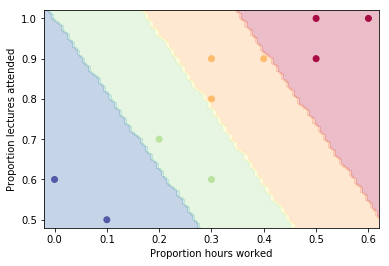

In [204]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_rank[:, 0], X_rank[:,1],  c=y, cmap=plt.cm.Spectral)
h = 0.01  # step size in the mesh
x_min, x_max = X_rank[:, 0].min() - 3*h, X_rank[:, 0].max() + 3*h
y_min, y_max = X_rank[:, 1].min() - 3*h, X_rank[:, 1].max() + 3*h

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
ones = np.ones(np.c_[xx.ravel(), yy.ravel()].shape[0]).reshape(-1,1)

X_grid = np.concatenate([np.c_[xx.ravel(), yy.ravel()], ones], axis=1)
yhat_grid = get_yhat(X_grid, w, b)

yhat_grid = yhat_grid.reshape(xx.shape)
CS = ax.contourf(xx, yy, yhat_grid, alpha = .3, cmap=plt.cm.Spectral)

ax.set_xlabel("Proportion hours worked")
ax.set_ylabel("Proportion lectures attended");
ax.set_xlim(x_min+h, x_max-h)
ax.set_ylim(y_min+h, y_max-h)

In [207]:
def pranking_print(X, y, T, k):
    np.random.seed(1234)
    n = X.shape[0] #number of samples
    vl =X.shape[1] #feature vector length
    w = np.zeros(vl)
    b = np.zeros(k-1)
    b = np.concatenate([b, [np.inf]])
    #init plotting stuff
    h = 0.01  # step size in the mesh
    x_min, x_max = X_rank[:, 0].min() - 3*h, X_rank[:, 0].max() + 3*h
    y_min, y_max = X_rank[:, 1].min() - 3*h, X_rank[:, 1].max() + 3*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    ones = np.ones(np.c_[xx.ravel(), yy.ravel()].shape[0]).reshape(-1,1)
    X_grid = np.concatenate([np.c_[xx.ravel(), yy.ravel()], ones], axis=1)  
    
    for i in range(T):
        #plotting bit
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(X[:, 0], X[:,1],  c=y, cmap=plt.cm.Spectral)
        ax.set_xlabel("Proportion hours worked")
        ax.set_ylabel("Proportion lectures attended");
        ax.set_xlim(x_min+h, x_max-h)
        ax.set_ylim(y_min+h, y_max-h)
        y_hat = get_yhat(X, w, b)
        yhat_grid = get_yhat(X_grid, w, b)
        yhat_grid = yhat_grid.reshape(xx.shape)
        CS = ax.contourf(xx, yy, yhat_grid, alpha = .3, cmap=plt.cm.Spectral)
        fig.show()
        
        if is_all_right(y, y_hat):
            print("converged")
            return w,b
        r_idx = np.random.randint(n)  
        y_hat_i = get_yhat_i(X, r_idx, w, b)
        if y_hat_i != y[r_idx]:
            #make true rank vector
            trv = [-1 if y[r_idx]<= r+1 else 1 for r in range(k-1)]
            #update w
            tau = [trv[r] if (np.dot(X[r_idx,:], w)-b[r])*trv[r]<=0 else 0 for r in range(k-1)]
            w_new = w + sum(tau)*X[r_idx,:]
            #update b
            b = [b[r]-tau[r] for r in range(k-1)] + [np.inf]
            w = w_new
    print("not converged")
    return w, b

/anaconda3/envs/pyenv361/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


converged


(array([-5.6, -3. ,  3. ]), [-2.0, -1.0, 0.0, inf])

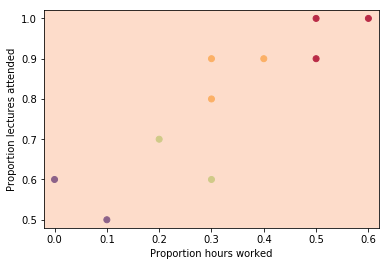

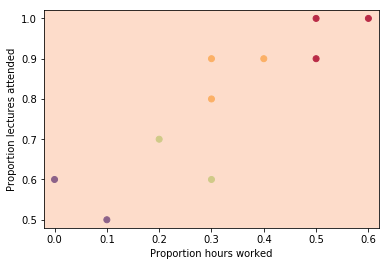

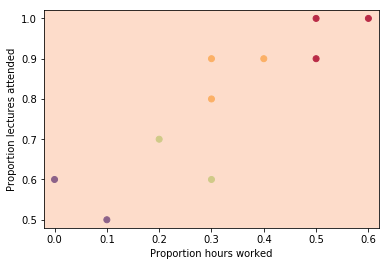

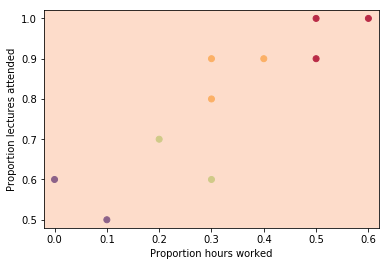

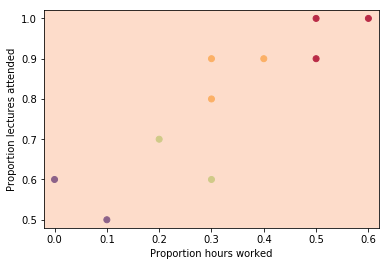

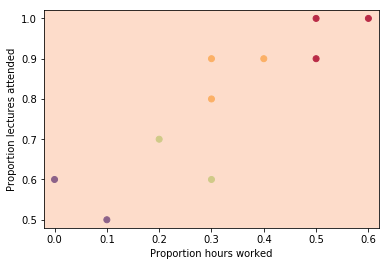

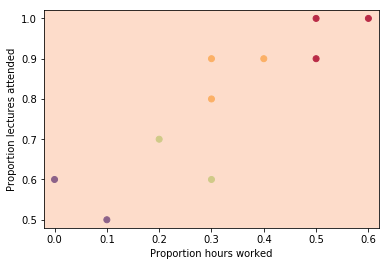

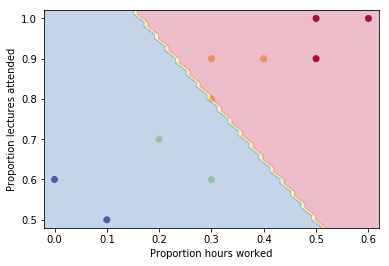

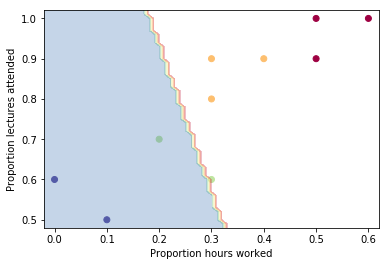

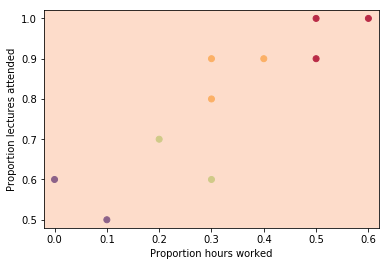

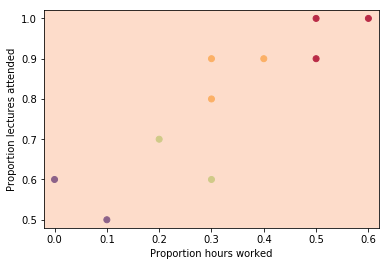

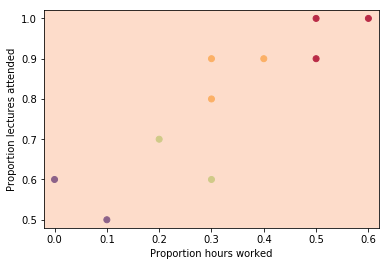

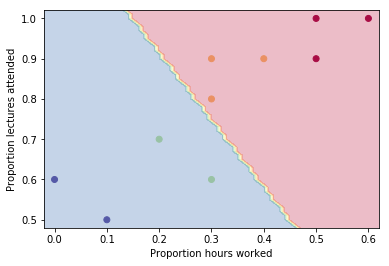

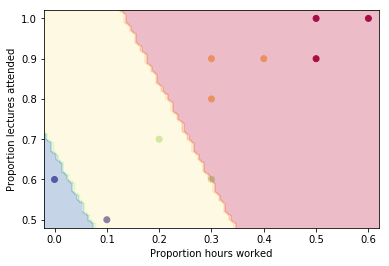

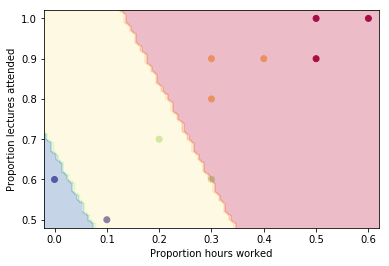

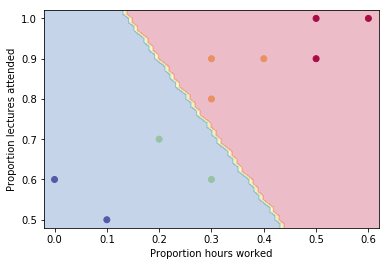

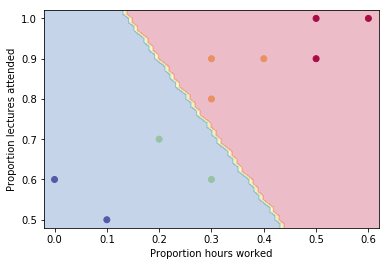

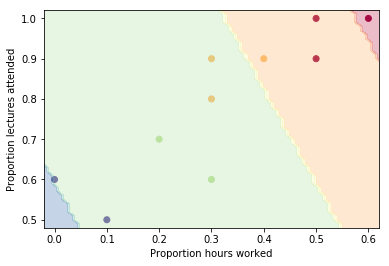

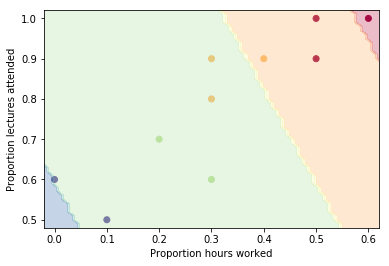

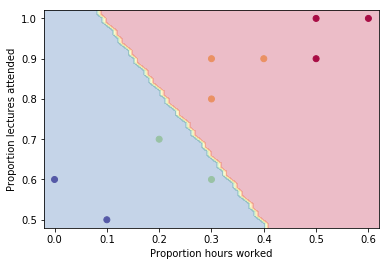

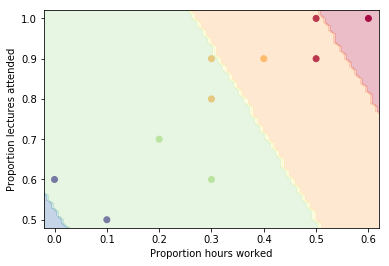

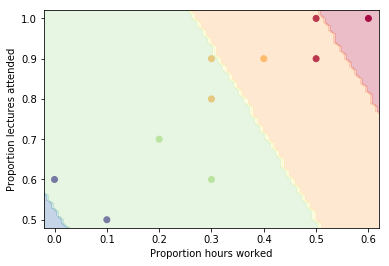

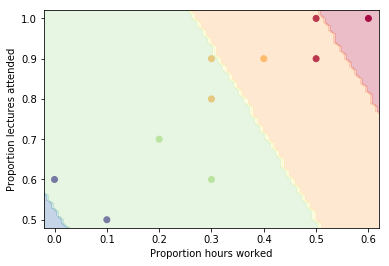

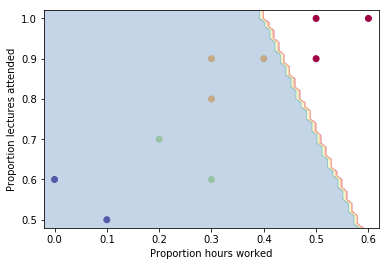

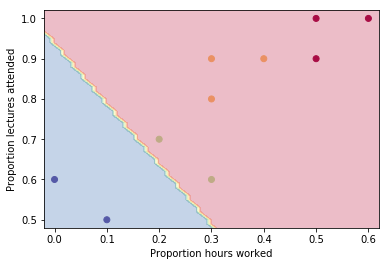

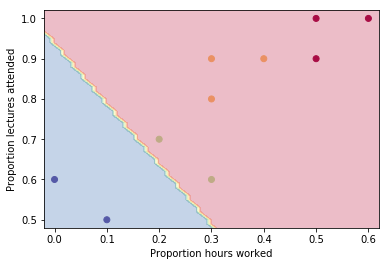

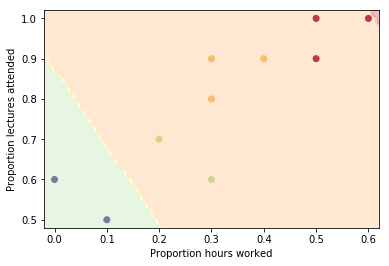

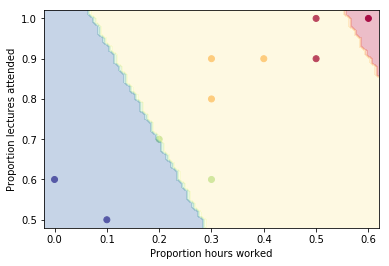

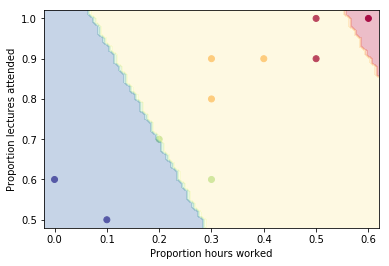

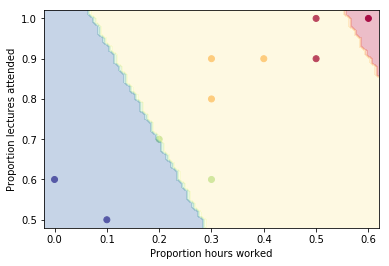

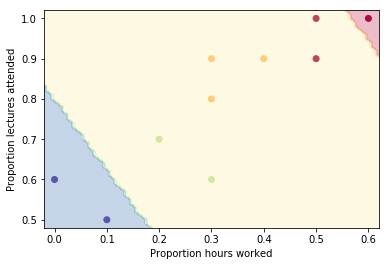

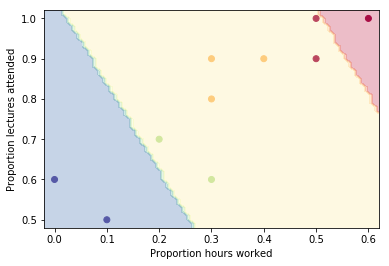

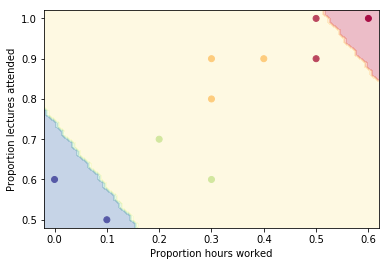

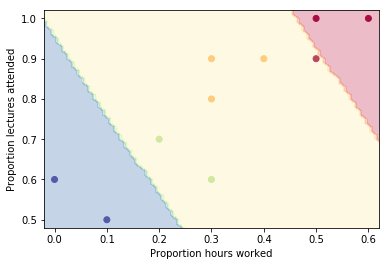

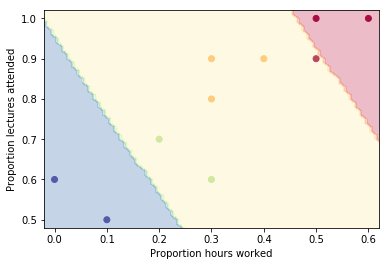

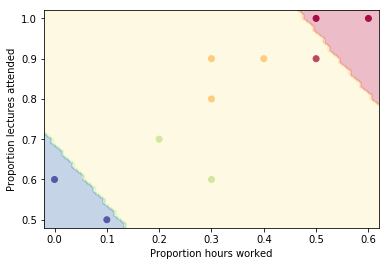

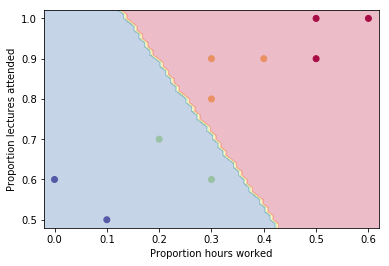

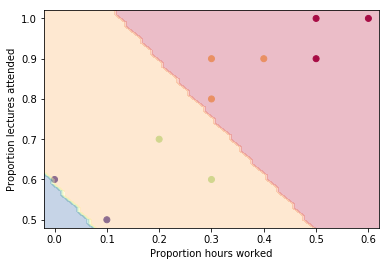

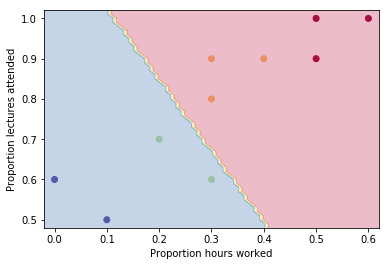

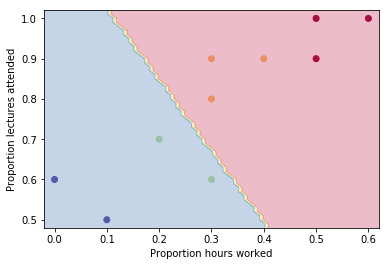

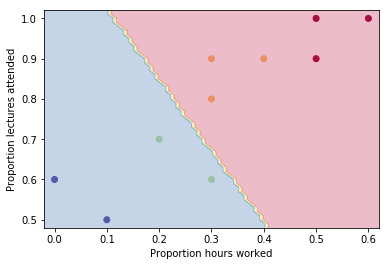

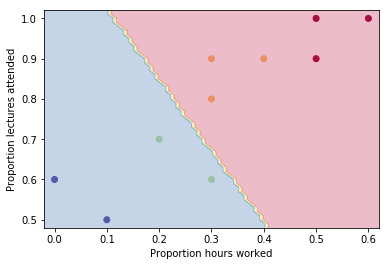

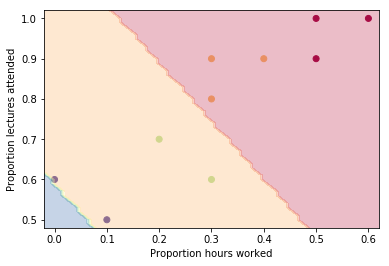

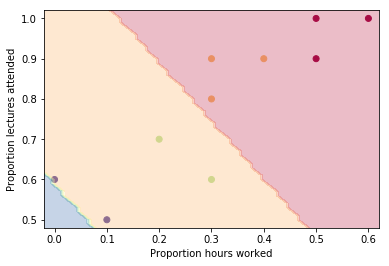

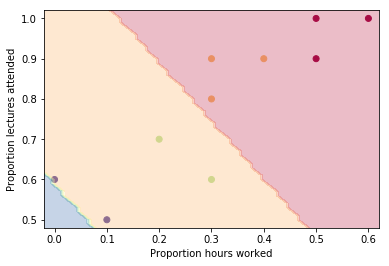

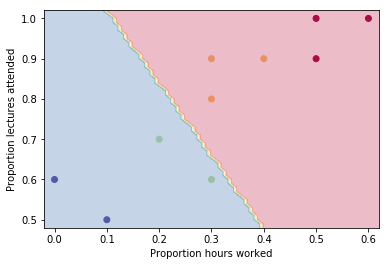

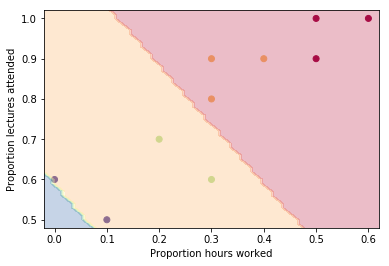

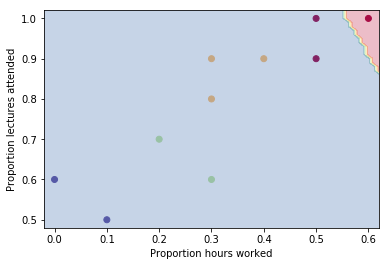

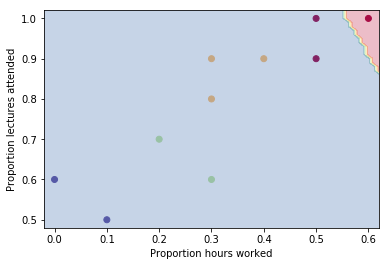

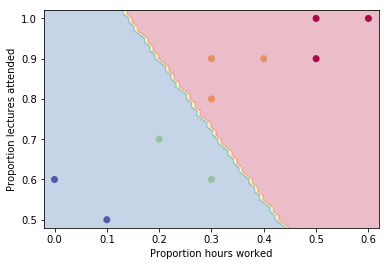

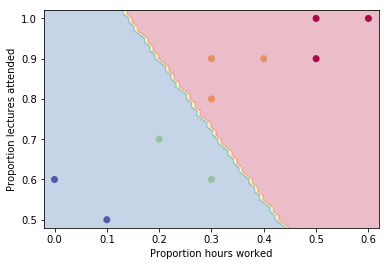

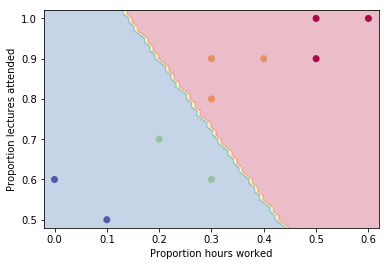

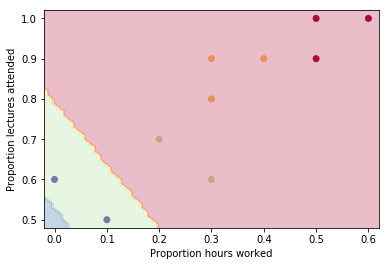

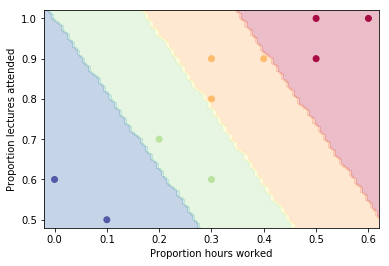

In [208]:
pranking_print(X_rank, y, 100, 4)

## Pairwise Ranking

Transform sample data

In [250]:
X_rank = np.array([[0.41, 0.92], [0.28, 0.83], [0.25, 0.73], [0.31, 0.62], [0.57, .96], [0.29, 0.91], [0.59, .97], [0.15, 0.53], [0.03, 0.58], [0.56, 0.84]])
y_rank = [2, 2, 3, 3, 1, 2, 1, 4, 4, 1]

def pair_transform(X, y):
    x_diff = []
    y_diff = []
    n = X.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            diff = y[i] - y[j]
            if diff ==0: 
                y_p = 0
            elif diff <0:
                y_p = -1
            else:
                y_p = 1
            X_p = X[i,:] - X[j,:]
            x_diff.append(X_p)
            y_diff.append(y_p)
    return np.array(x_diff), np.array(y_diff)

X_p, y_p = pair_transform(X_rank, y_rank)

        


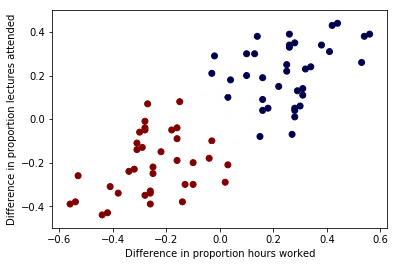

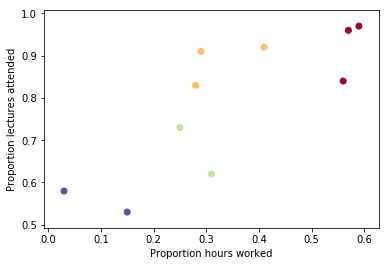

In [251]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_p[:, 0], X_p[:,1],  c=y_p, cmap=plt.cm.seismic)
ax.set_xlabel("Difference in proportion hours worked")
ax.set_ylabel("Difference in proportion lectures attended")

plt.savefig("./images/pair_plot.png", bbox_inches='tight');
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_rank[:, 0], X_rank[:,1],  c=y_rank, cmap=plt.cm.Spectral)
ax.set_xlabel("Proportion hours worked")
ax.set_ylabel("Proportion lectures attended")

plt.savefig("./images/rank_plot.png", bbox_inches='tight');
plt.show();

In [252]:
X_p[:10,:]

array([[ 0.13,  0.09],
       [ 0.16,  0.19],
       [ 0.1 ,  0.3 ],
       [-0.16, -0.04],
       [ 0.12,  0.01],
       [-0.18, -0.05],
       [ 0.26,  0.39],
       [ 0.38,  0.34],
       [-0.15,  0.08],
       [-0.13, -0.09]])

thurstone 

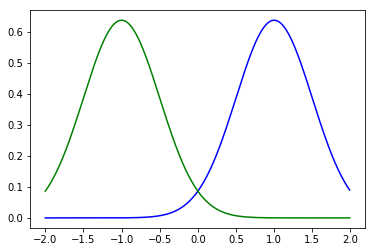

In [260]:
def gaussian(mu, sigma, X):
    res = []
    for i in range(X.shape[0]):
        g = 1/(2*np.pi*sigma**2)*np.exp(-((X[i]-mu)**2)/(2*sigma**2))
        res.append(g)
    return np.array(res)

x_i = np.arange(-2,2,0.01)
y_i = gaussian(1, 0.5, x_i)

x_j = np.arange(-2,2,0.01)
y_j = gaussian(-1, 0.5, x_j)
plt.plot(x_i, y_i, 'b-', x_j, y_j, 'g-')
plt.savefig("./images/thurstone.png", bbox_inches='tight');